# Latent Variable Models: PCA to Kalman Filtering

In this notebook, we'll simulate a 2D latent dynamical system that generates high-dimensional observations, and then explore how different latent variable models (PCA, Factor Analysis, and Kalman Filtering) can be used to infer the hidden states.

We'll see how progressively richer statistical models help us recover latent structure more accurately by incorporating better probabilistic modeling and temporal dynamics.


In [1]:
import torch
import xfads.utils as utils
import matplotlib.pyplot as plt
import xfads.prob_utils as prob_utils
import pytorch_lightning as lightning

from hydra import compose, initialize
from sklearn.decomposition import PCA
from xfads.linalg_utils import bmv, chol_bmv_solve, triangular_inverse
from xfads.prob_utils import kalman_information_filter, rts_smoother, align_latent_variables, construct_hankel

initialize(version_base=None, config_path="", job_name="lds")
cfg = compose(config_name="config")
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1234


## Simulating Data from a Latent Dynamical System

We simulate a **2D spiral attractor** in the latent space. This latent state evolves over time and is projected into a high-dimensional neural observation space via a linear readout matrix. We add Gaussian noise to model observation uncertainty.

This synthetic setup mimics common situations in neuroscience and time-series analysis, where observed data are noisy and high-dimensional, but governed by low-dimensional latent dynamics.


In [2]:
# Simulation parameters
n_neurons = 50
n_trials = 1000
n_time_bins = 50
n_samples = 5

omega, rho = 3.14 / 8.0, 0.97
mean_fn = utils.SpiralDynamics(omega, rho)

C = utils.FanInLinear(2, n_neurons, device="cpu").requires_grad_(False)
Q_diag = 3e-2 * torch.ones(2)
Q_0_diag = 1.0 * torch.ones(2)
R_diag = 1.0 * torch.ones(n_neurons)
m_0 = torch.zeros(2)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn_like(C(z))

# Split data
n_valid = n_trials // 3
n_train = n_trials - n_valid
y_train, z_train = y[:n_train], z[:n_train]
y_valid, z_valid = y[n_train:], z[n_train:]

## Visualize True Latents

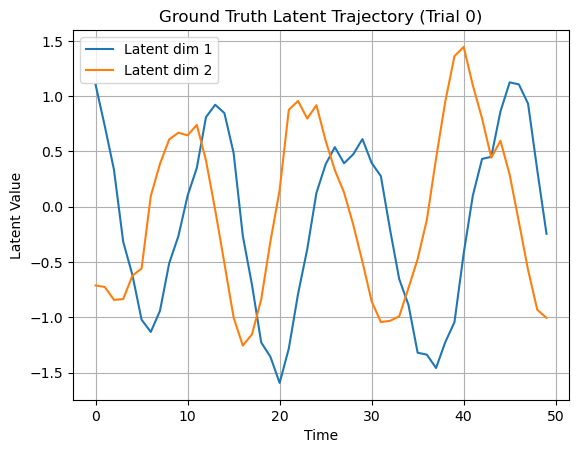

In [3]:
plt.plot(z[0, :, 0], label="Latent dim 1")
plt.plot(z[0, :, 1], label="Latent dim 2")
plt.legend()
plt.title("Ground Truth Latent Trajectory (Trial 0)")
plt.xlabel("Time")
plt.ylabel("Latent Value")
plt.grid(True)

## 1: Principal Component Analysis (PCA)

PCA is a classical linear method that finds directions of maximum variance in the data. While simple and efficient, it doesn't account for time or noise, and assumes the entire dataset lies on a linear subspace.

Still, PCA often works surprisingly well as a baseline.


In [4]:
pca = PCA(n_components=2)
pca.fit(y_train.reshape(-1, n_neurons))
m_pca = pca.transform(y_valid.reshape(-1, n_neurons))
m_pca = torch.tensor(m_pca.reshape(n_valid, n_time_bins, -1), dtype=torch.float32)


## 2: Factor Analysis

Factor Analysis (FA) is a probabilistic version of PCA. It models the noise in each observation dimension and finds latent variables that explain shared structure across variables.

However, FA still treats each time point independently, ignoring dynamics entirely.


In [5]:
J_fa = (C.weight.mT / R_diag) @ C.weight + torch.diag(1 / Q_diag)
J_fa_chol = torch.linalg.cholesky(J_fa)
P_fa_chol = triangular_inverse(J_fa_chol).mT
m_fa = chol_bmv_solve(J_fa_chol, bmv(C.weight.mT, (y_valid - C.bias)))
z_fa = m_fa.unsqueeze(0) + bmv(P_fa_chol, torch.randn((n_samples, n_valid, n_time_bins, cfg.n_latents)))


## 3: Kalman Filtering and Smoothing

Kalman filters model latent state transitions over time. They combine current observations with prior dynamics to estimate the most likely latent states at each time step.

This is the first model in our chain that fully incorporates temporal structure.


In [6]:
h_update = bmv(C.weight.T, (y_valid - C.bias) / R_diag)
J_update = (C.weight.T / R_diag) @ C.weight
J_update = J_update.expand(y_valid.shape[0], n_time_bins, cfg.n_latents, cfg.n_latents)

m_f, P_f, m_p, P_p = kalman_information_filter(h_update, J_update, mean_fn.A, Q_diag, m_0, Q_0_diag)
m_s, P_s, P_tp1_t_s, z_s = rts_smoother(m_p, P_p, m_f, P_f, mean_fn.A, n_samples=n_samples)

## Comparisons

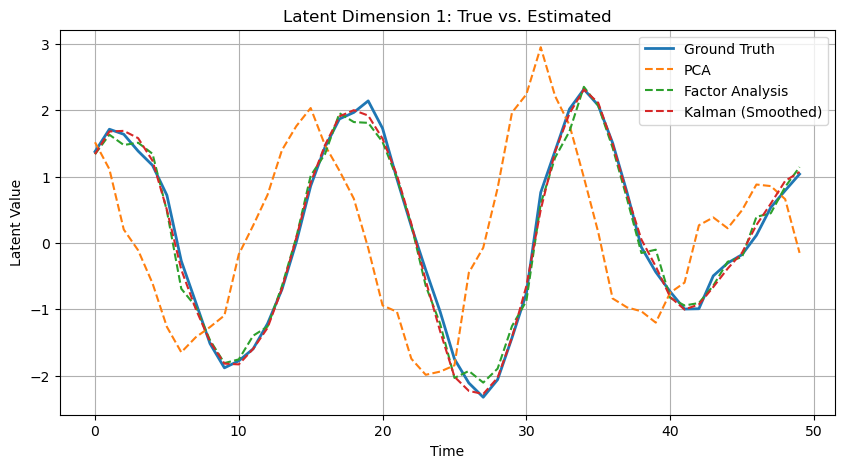

In [7]:
rot_pca, m_rot_pca = align_latent_variables(z_valid, m_pca)
rot_fa, m_rot_fa = align_latent_variables(z_valid, m_fa)
rot_s, m_rot_s = align_latent_variables(z_valid, m_s)

plt.figure(figsize=(10, 5))
plt.plot(z_valid[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(m_rot_pca[0, :, 0], label='PCA', linestyle='--')
plt.plot(m_rot_fa[0, :, 0], label='Factor Analysis', linestyle='--')
plt.plot(m_rot_s[0, :, 0], label='Kalman (Smoothed)', linestyle='--')
plt.title("Latent Dimension 1: True vs. Estimated")
plt.xlabel("Time")
plt.ylabel("Latent Value")
plt.legend()
plt.grid(True)

# Learning Latent Dynamics Parameters

So far, we assumed access to the true dynamics and observation parameters. But in practice, these must be estimated from data.

We'll now explore two approaches for learning the parameters of a Linear Dynamical System (LDS):

1. **System Identification** using the **Kalman-Ho algorithm** (a subspace method).
2. **Expectation-Maximization (EM)** for LDS parameter learning (a probabilistic approach).

We'll compare their learned state transition matrices via their eigenvalues.


## Kalman-Ho System Identification

The Kalman-Ho algorithm is a classic subspace identification method. It works by constructing a Hankel matrix from the observed outputs and applying an SVD to extract latent dynamics.

This method is **non-probabilistic**, fast, and often used in control and system ID applications.


In [8]:
# Construct Hankel matrix
H_hankel = prob_utils.construct_hankel(y_valid, 50, 50)

# Estimate system matrices using Kalman-Ho
A_hat_kh, B_hat_kh, C_hat_kh = prob_utils.get_kalman_ho_estimates(
    H_hankel, n_neurons, cfg.n_latents
)

# Eigenvalues of learned A
eig_vals_kh_hat = torch.linalg.eigvals(A_hat_kh)


## EM for LDS Parameter Estimation

The EM algorithm is a probabilistic approach to estimating LDS parameters. It alternates between:

- **E-step**: Inferring latent trajectories (here, using RTS smoothing).
- **M-step**: Updating parameters to maximize the expected complete-data log-likelihood.

This method can be more accurate and flexible, especially with noise or missing data.


In [9]:
# Estimate parameters using EM
A_hat_em, C_hat_em, Q_hat_em, R_hat_em = prob_utils.em_update_batch(m_s, P_s, P_tp1_t_s, y_valid)

# Eigenvalues of learned A
eig_vals_em_hat = torch.linalg.eigvals(A_hat_em)
